In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook

import sys
print(sys.version)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


from classy import Class
import scipy.interpolate


from scipy.interpolate import interp1d, interp2d
import math
import scipy.special as sp

import os
from time import time

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


## Vamos começar definindo parâmetros para uma cosmologia de referência:

In [2]:
Om_ref = 0.3
Ob_ref = 0.049
Oc_ref = Om_ref - Ob_ref
wDE_ref = -1.0
h_ref = 0.67
ns_ref = 0.965
As_ref = 2.1e-09
Onu_ref = 0.0
sig8_ref = 0.85


k_per_decade = 30#180     # number of k values, controls final resolution
P_k_max_h_Mpc = 10   # this value is directly the maximum k value in the figure in Mpc

# Cálculo de Observáveis teóricos

In [4]:
# 1) Função que devolve o dicionário baseline (para fácil cópia)
def build_baseline_params():
    params = {
        # -------------------- SAÍDAS --------------------
        'modes'  : 's',
        'output' : 'tCl, pCl, lCl',
        'lensing': 'yes',
        'l_max_scalars': 3000,

        # ----------------- COSMOLOGIA -------------------
        # DE como fld (Ω_Λ=0 e w0/wa dados)
        'Omega_Lambda': 0,
        'w0_fld'      : '-1.',
        'wa_fld'      : '0.0',

        # Primordial
        'sigma8': sig8_ref,
        'n_s'   : ns_ref,

        # Verbosidade/Gauge
        'background_verbose'   : 0,
        'perturbations_verbose': 0,
        'gauge'                : 'Synchronous',

        # Fundo
        'h'        : h_ref,
        'Omega_b'  : Ob_ref,
        'Omega_cdm': Om_ref - Ob_ref,  # valor fiducial
        # Se for usar neutrinos, ajuste N_ur/N_ncdm conforme seu setup:
        # 'N_ur'   : 3.046,
        # 'N_ncdm' : 0,
        # Curvatura (fiducial plana)
        'Omega_k'  : 0.0,
    }
    return params

### Decomposição das anisotropias de temperatura da CMB (com early e late ISW)

A flutuação de temperatura observada em uma direção $\hat{n}$ pode ser escrita como:

$
\frac{\delta T}{T}(\hat{n}) =
\underbrace{\left( \frac{\delta T}{T} + \Psi + \hat{n} \cdot \mathbf{v}_b \right)_{\mathrm{LSS}}}_{\text{Sachs–Wolfe + Doppler}}
\;+\;
\underbrace{
\int_{\eta_{\mathrm{LSS}}}^{\eta_{\mathrm{eq}}} d\eta \, (\dot{\Psi} + \dot{\Phi})
}_{\text{early ISW}}
\;+\;
\underbrace{
\int_{\eta_{\mathrm{eq}}}^{\eta_{0}} d\eta \, (\dot{\Psi} + \dot{\Phi})
}_{\text{late ISW}}
$

onde:

- **Termo Sachs–Wolfe (SW):**  
  $
  \left( \frac{\delta T}{T} + \Psi \right)_{\mathrm{LSS}}
  $
  representa a soma da flutuação intrínseca da temperatura e do redshift gravitacional no último espalhamento.

- **Termo Doppler:**  
  $
  (\hat{n} \cdot \mathbf{v}_b)_{\mathrm{LSS}}
  $
  vem do movimento do fluido bárion–fóton.

- **Efeito ISW (Integrated Sachs–Wolfe):**
  $
  \int d\eta \, (\dot{\Psi} + \dot{\Phi})
  $
  mede a variação temporal dos potenciais gravitacionais ao longo da linha de visada.

  - **Early ISW:** surge durante a transição entre domínios de radiação e matéria, quando os potenciais ainda não são constantes.  
  - **Late ISW:** aparece em tempos recentes, quando a energia escura ou a curvatura fazem os potenciais decaírem novamente.

---

💡 **Resumo físico:**
- O **SW** e o **Doppler** vêm do último espalhamento (superfície de desacoplamento).  
- O **early ISW** altera o primeiro pico acústico (afetando escalas intermediárias).  
- O **late ISW** gera correlações adicionais em grandes escalas (pequenos $\ell$), detectáveis por correlação entre mapas de CMB e estruturas de grande escala.


✓ TSW
✓ eISW
✓ lISW
... pulando ISW(total): 

Error in Class: input_read_from_file(L:420) :error in input_shooting(pfc,ppr,pba,pth,ppt,ptr,ppm,phr,pfo,ple,psd,pop, input_verbose, &has_shooting, errmsg);
=>input_shooting(L:821) :error in input_try_unknown_parameters(&A_s, 1, &fzw, &sigma8_or_S8, errmsg);
=>input_try_unknown_parameters(L:1355) :error in input_read_parameters(&(pfzw->fc),&pr,&ba,&th,&pt,&tr,&pm,&hr,&fo,&le,&sd,&op, errmsg);
=>input_read_parameters(L:1673) :error in input_read_parameters_general(pfc,pba,pth,ppt,pfo,psd, errmsg);
=>input_read_parameters_general(L:1882) :condition (flag1==_FALSE_) is true; The options for 'temperature_contributions' are {'tsw','eisw','lisw','dop','pol'}, you entered 'isw'
✓ Doppler
✓ Polarization


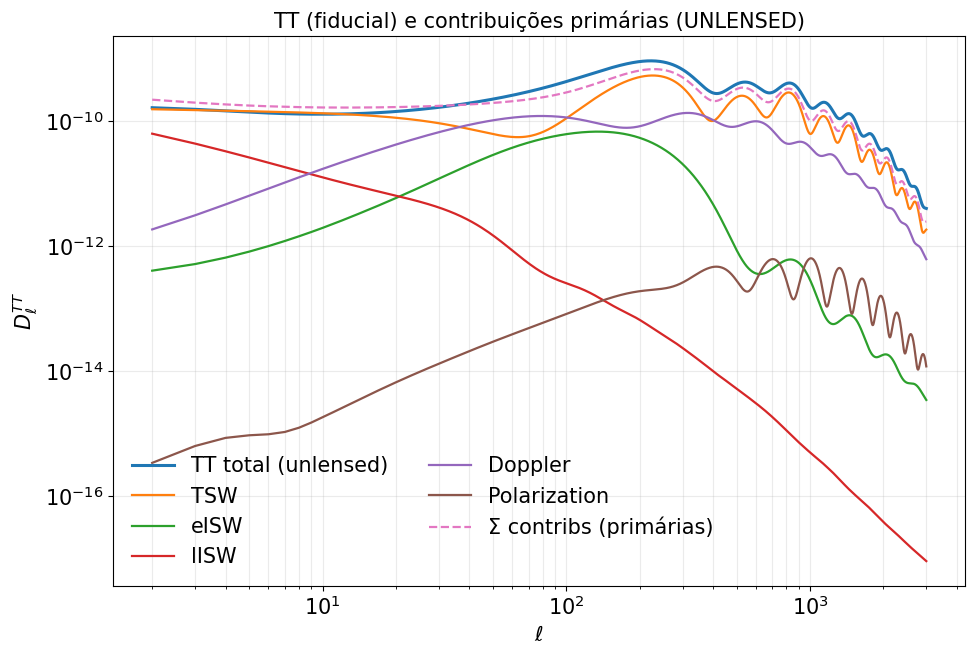

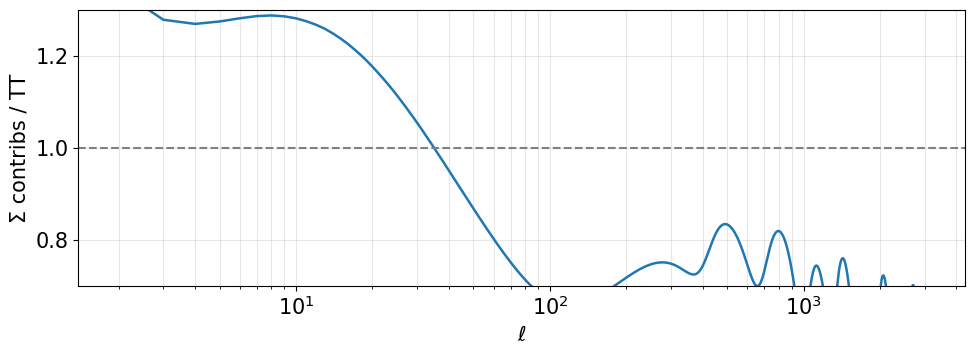

In [6]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

def Dl(ell, cl): return ell*(ell+1)*cl/(2*np.pi)

base = build_baseline_params()
lmax = int(base.get('l_max_scalars', 3000))

# --- 1) Uma única rodada para TT total (unlensed e lensed) ---
pars_tot = dict(base)
pars_tot.update({'modes':'s','lensing':'yes','output':'tCl,pCl,lCl'})
M = Class(); M.set(pars_tot); M.compute()

raw    = M.raw_cl(lmax)       # UNLENSED total
lensed = M.lensed_cl(lmax)    # LENSED total

ell     = np.asarray(raw['ell'])
clTT_u  = np.asarray(raw['tt'])
ell_L   = np.asarray(lensed['ell'])   # <<< grade do lensed
clTT_L  = np.asarray(lensed['tt'])    # <<< espectro lensed

M.struct_cleanup(); M.empty()

# --- 2) Rodadas separadas para contribuições primárias (sempre UNLENSED) ---
def get_contrib(flag):
    Mi = Class()
    pars_c = dict(base)
    pars_c.update({'modes':'s','lensing':'no','output':'tCl',
                   'temperature contributions': flag})
    Mi.set(pars_c); Mi.compute()
    rc = Mi.raw_cl(lmax)
    e  = np.asarray(rc['ell']); tt = np.asarray(rc['tt'])
    Mi.struct_cleanup(); Mi.empty()
    return e, tt

contrib_flags = [('tsw','TSW'), ('eisw','eISW'), ('lisw','lISW'),
                 ('isw','ISW(total)'), ('dop','Doppler'), ('pol','Polarization')]
contribs = []
for flg, lab in contrib_flags:
    try:
        e_c, tt_c = get_contrib(flg)
        # traz para a grade de 'ell' (a mesma que usaremos para E)
        if not np.array_equal(e_c, ell):
            tt_c = np.interp(ell, e_c, tt_c)
        contribs.append((lab, tt_c))
        print(f"✓ {lab}")
    except Exception as ex:
        print(f"... pulando {lab}: {ex}")

# remove ISW(total) se houver split eISW/lISW
labels = [lab for lab,_ in contribs]
if ('eISW' in labels) and ('lISW' in labels):
    contribs = [(lab,arr) for lab,arr in contribs if lab!='ISW(total)']

# soma das contribuições disponíveis (na grade 'ell')
sum_contrib = np.sum([arr for _,arr in contribs], axis=0) if contribs else None

# --- 3) Constrói grade alvo (sem ell<2) e interpola tudo para E ---
E = ell[ell >= 2]                               # grade final de plot
Dl_TT_unl = Dl(E, np.interp(E, ell,   clTT_u))  # TT unlensed
Dl_TT_len = Dl(E, np.interp(E, ell_L, clTT_L))  # TT lensed (usa ell_L!)

curvas = [('TT total (unlensed)', Dl_TT_unl)]
for lab, arr in contribs:
    curvas.append((lab, Dl(E, np.interp(E, ell, arr))))
if sum_contrib is not None:
    curvas.append(('Σ contribs (primárias)',
                   Dl(E, np.interp(E, ell, sum_contrib))))

# --- 4) Plots (um único bloco, sem usar 'mask') ---
plt.figure(figsize=(10,6.8))
for lab, y in curvas:
    style = {'ls':'--'} if 'Σ contribs' in lab else {}
    lw = 2.2 if lab.startswith('TT total') else 1.6
    plt.plot(E, y, lw=lw, label=lab, **style)
#plt.plot(E, Dl_TT_len, lw=1.8, ls=':', label='TT (lensed)')

plt.xscale('log'); plt.yscale('log'); plt.grid(alpha=0.25, which='both')
plt.xlabel(r'$\ell$'); plt.ylabel(r'$D_\ell^{TT}$')
plt.title('TT (fiducial) e contribuições primárias (UNLENSED)')
plt.legend(frameon=False, ncol=2)
plt.tight_layout(); plt.show()

# --- 5) Ratio Σ contribs / TT (na grade E) ---
if sum_contrib is not None:
    num = np.interp(E, ell, sum_contrib)
    den = np.interp(E, ell, clTT_u)
    ratio = np.where(den!=0, num/den, np.nan)
    plt.figure(figsize=(10,3.8))
    plt.semilogx(E, ratio, lw=1.8); plt.axhline(1.0, ls='--', color='gray')
    plt.ylim(0.7, 1.3)
    plt.xlabel(r'$\ell$'); plt.ylabel('Σ contribs / TT')
    plt.grid(alpha=0.3, which='both')
    plt.tight_layout(); plt.show()
else:
    print("⚠️ Nenhuma contribuição disponível para somar.")


✓ auto: SW
✓ auto: eISW
✓ auto: lISW
... pulando ISW(total): 

Error in Class: input_read_from_file(L:420) :error in input_shooting(pfc,ppr,pba,pth,ppt,ptr,ppm,phr,pfo,ple,psd,pop, input_verbose, &has_shooting, errmsg);
=>input_shooting(L:821) :error in input_try_unknown_parameters(&A_s, 1, &fzw, &sigma8_or_S8, errmsg);
=>input_try_unknown_parameters(L:1355) :error in input_read_parameters(&(pfzw->fc),&pr,&ba,&th,&pt,&tr,&pm,&hr,&fo,&le,&sd,&op, errmsg);
=>input_read_parameters(L:1673) :error in input_read_parameters_general(pfc,pba,pth,ppt,pfo,psd, errmsg);
=>input_read_parameters_general(L:1882) :condition (flag1==_FALSE_) is true; The options for 'temperature_contributions' are {'tsw','eisw','lisw','dop','pol'}, you entered 'isw'
✓ auto: Doppler
✓ auto: Polarization
✓ combinado (todas as fontes) via 'tsw,eisw,lisw,dop,pol'


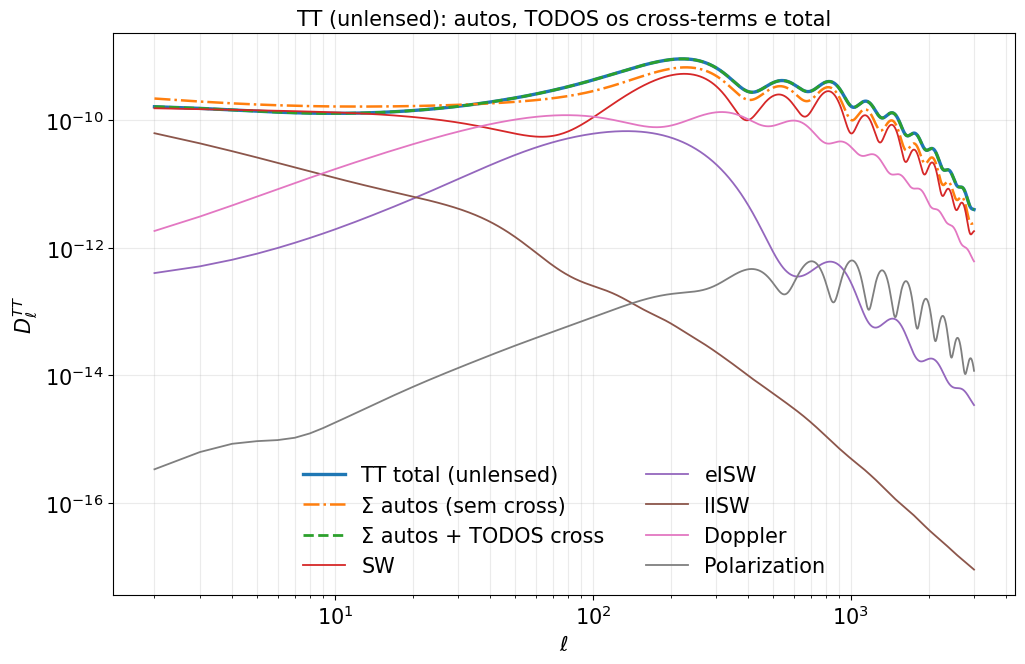

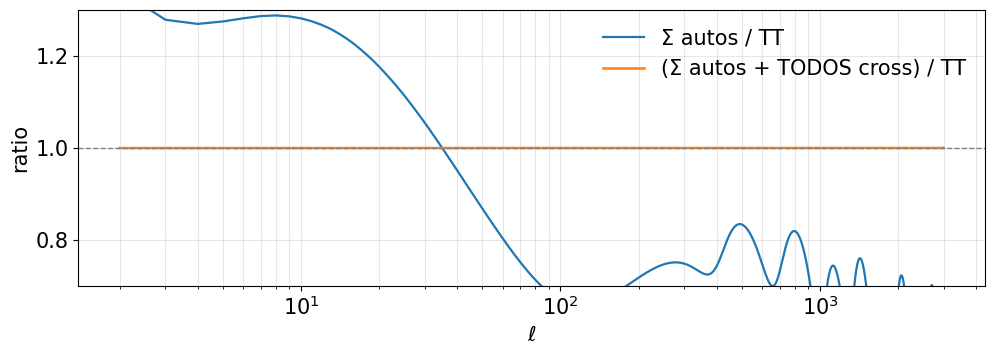

In [7]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

def Dl(ell, cl): return ell*(ell+1)*cl/(2*np.pi)

base = build_baseline_params()
lmax = int(base.get('l_max_scalars', 3000))

# ---------- 1) TT total (unlensed e lensed numa só rodada) ----------
pars_tot = dict(base)
pars_tot.update({'modes':'s','lensing':'yes','output':'tCl,pCl,lCl'})
M = Class(); M.set(pars_tot); M.compute()
raw    = M.raw_cl(lmax)       # UNLENSED total
lensed = M.lensed_cl(lmax)    # LENSED total
ell    = np.asarray(raw['ell'])
clTT_u = np.asarray(raw['tt'])
ell_L  = np.asarray(lensed['ell'])
clTT_L = np.asarray(lensed['tt'])
M.struct_cleanup(); M.empty()

# ---------- 2) helper para pegar uma contribuição específica (sempre UNLENSED) ----------
def get_contrib(flag_str):
    Mi = Class()
    pars_c = dict(base)
    pars_c.update({'modes':'s','lensing':'no','output':'tCl',
                   'temperature contributions': flag_str})
    Mi.set(pars_c); Mi.compute()
    rc = Mi.raw_cl(lmax)
    e  = np.asarray(rc['ell']); tt = np.asarray(rc['tt'])
    Mi.struct_cleanup(); Mi.empty()
    return e, tt

# ---------- 3) autos: SW, eISW/lISW (ou ISW total), Doppler, Polarization ----------
want = [
    ('tsw',  'SW'),
    ('eisw', 'eISW'),
    ('lisw', 'lISW'),
    ('isw',  'ISW(total)'),  # fallback
    ('dop',  'Doppler'),
    ('pol',  'Polarization')
]
autos = {}
for key, label in want:
    try:
        e, tt = get_contrib(key)
        if not np.array_equal(e, ell):
            tt = np.interp(ell, e, tt)
        autos[label] = tt
        print(f"✓ auto: {label}")
    except Exception as ex:
        print(f"... pulando {label}: {ex}")

# se tem eISW e lISW, remova ISW(total) para evitar dupla contagem
if ('eISW' in autos) and ('lISW' in autos) and ('ISW(total)' in autos):
    autos.pop('ISW(total)')

sum_autos = np.sum([arr for arr in autos.values()], axis=0) if autos else None

# ---------- 4) TODAS as contribuições juntas (auto + TODOS os cross-terms) ----------
# tentativas dependendo da build:
combos_all = [
    'tsw,eisw,lisw,dop,pol',            # split ISW
    'tsw+eisw+lisw+dop+pol',
    'tsw,isw,dop,pol',                  # ISW total (sem split)
    'tsw+isw+dop+pol'
]
cl_all_combined = None
for combo in combos_all:
    try:
        e_cmb, tt_cmb = get_contrib(combo)
        if not np.array_equal(e_cmb, ell):
            tt_cmb = np.interp(ell, e_cmb, tt_cmb)
        cl_all_combined = tt_cmb
        print(f"✓ combinado (todas as fontes) via '{combo}'")
        break
    except Exception as ex:
        print(f"... tentativa '{combo}' falhou: {ex}")

# essa curva já inclui autos + TODOS os cross-terms entre as fontes listadas
sum_autos_plus_all_cross = cl_all_combined

# ---------- 5) grade final e séries ----------
E = ell[ell >= 2]
series = []
series.append(('TT total (unlensed)', Dl(E, np.interp(E, ell,   clTT_u))))
if sum_autos is not None:
    series.append(('Σ autos (sem cross)', Dl(E, np.interp(E, ell, sum_autos))))
if sum_autos_plus_all_cross is not None:
    series.append(('Σ autos + TODOS cross', Dl(E, np.interp(E, ell, sum_autos_plus_all_cross))))
# contribuições individuais (inclui Polarization)
for label, arr in autos.items():
    series.append((label, Dl(E, np.interp(E, ell, arr))))
# lensed (referência, opcional)
Dl_TT_len = Dl(E, np.interp(E, ell_L, clTT_L))

# ---------- 6) plots ----------
plt.figure(figsize=(10.5,6.9))
for lab, y in series:
    if lab == 'TT total (unlensed)':
        plt.plot(E, y, lw=2.4, label=lab)
    elif lab == 'Σ autos + TODOS cross':
        plt.plot(E, y, lw=2.0, ls='--', label=lab)
    elif lab == 'Σ autos (sem cross)':
        plt.plot(E, y, lw=1.8, ls='-.', label=lab)
    else:
        plt.plot(E, y, lw=1.3, label=lab)
# plt.plot(E, Dl_TT_len, lw=1.6, ls=':', label='TT (lensed)')  # opcional

plt.xscale('log'); plt.yscale('log'); plt.grid(alpha=0.25, which='both')
plt.xlabel(r'$\ell$'); plt.ylabel(r'$D_\ell^{TT}$')
plt.title('TT (unlensed): autos, TODOS os cross-terms e total')
plt.legend(frameon=False, ncol=2)
plt.tight_layout(); plt.show()

# ---------- 7) ratios ----------
if sum_autos is not None:
    den = np.interp(E, ell, clTT_u)
    plt.figure(figsize=(10.2,3.8))
    r1 = np.where(den!=0, np.interp(E, ell, sum_autos)/den, np.nan)
    plt.semilogx(E, r1, lw=1.6, label='Σ autos / TT')
    if sum_autos_plus_all_cross is not None:
        r2 = np.where(den!=0, np.interp(E, ell, sum_autos_plus_all_cross)/den, np.nan)
        plt.semilogx(E, r2, lw=1.8, label='(Σ autos + TODOS cross) / TT')
    plt.axhline(1.0, color='gray', ls='--', lw=1)
    plt.ylim(0.7, 1.3)
    plt.xlabel(r'$\ell$'); plt.ylabel('ratio')
    plt.grid(alpha=0.3, which='both'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()


### Termos cruzados no espectro angular de temperatura

O espectro angular de anisotropias de temperatura da CMB é definido como:

$
C_\ell^{TT} = \langle a_{\ell m}^T \, (a_{\ell m}^T)^* \rangle
$

onde os coeficientes $ a_{\ell m}^T $ vêm da soma das contribuições físicas:

$
a_{\ell m}^T = a_{\ell m}^{\mathrm{SW}}
+ a_{\ell m}^{\mathrm{ISW}}
+ a_{\ell m}^{\mathrm{Dop}}
+ a_{\ell m}^{\mathrm{Pol}} + \cdots
$
    
Substituindo na definição de $ C_\ell^{TT} $:

$
C_\ell^{TT}
= \langle |a_{\ell m}^{\mathrm{SW}}|^2 \rangle
+ \langle |a_{\ell m}^{\mathrm{ISW}}|^2 \rangle
+ 2\,\Re\left[ \langle a_{\ell m}^{\mathrm{SW}} (a_{\ell m}^{\mathrm{ISW}})^* \rangle \right]
+ \cdots
$

O **termo cruzado SW×ISW** aparece naturalmente aqui:

$
C_\ell^{\mathrm{SW-ISW}}
= 2\,\Re\left[ \langle a_{\ell m}^{\mathrm{SW}} (a_{\ell m}^{\mathrm{ISW}})^* \rangle \right]
$

e representa a **correlação entre as flutuações do potencial gravitacional no último espalhamento e sua evolução ao longo da linha de visada**.

---

### Interpretação física

- O **SW** depende do potencial gravitacional na época do último espalhamento:  
  $
  \left(\frac{\delta T}{T}\right)_{\mathrm{SW}} = \frac{\Phi}{3}
  $
  em grandezas newtonianas.

- O **ISW** depende da variação temporal dos potenciais:  
  $
  \left(\frac{\delta T}{T}\right)_{\mathrm{ISW}} = \int d\eta \, (\dot{\Phi} + \dot{\Psi})
  $

Como ambos envolvem os mesmos potenciais $\Phi$ e $\Psi$, suas fases e amplitudes estão **correlacionadas**, produzindo um termo de interferência positiva ou negativa conforme a escala.

---

💡 **Resumo:**
- $C_\ell^{TT}$ **não é** a soma simples das potências individuais.  
- O termo cruzado $C_\ell^{\mathrm{SW-ISW}}$ surge da correlação estatística entre as fontes.  
- É esse termo que “reconcilia” a diferença entre a soma dos auto-termos e o espectro total calculado pelo CLASS.


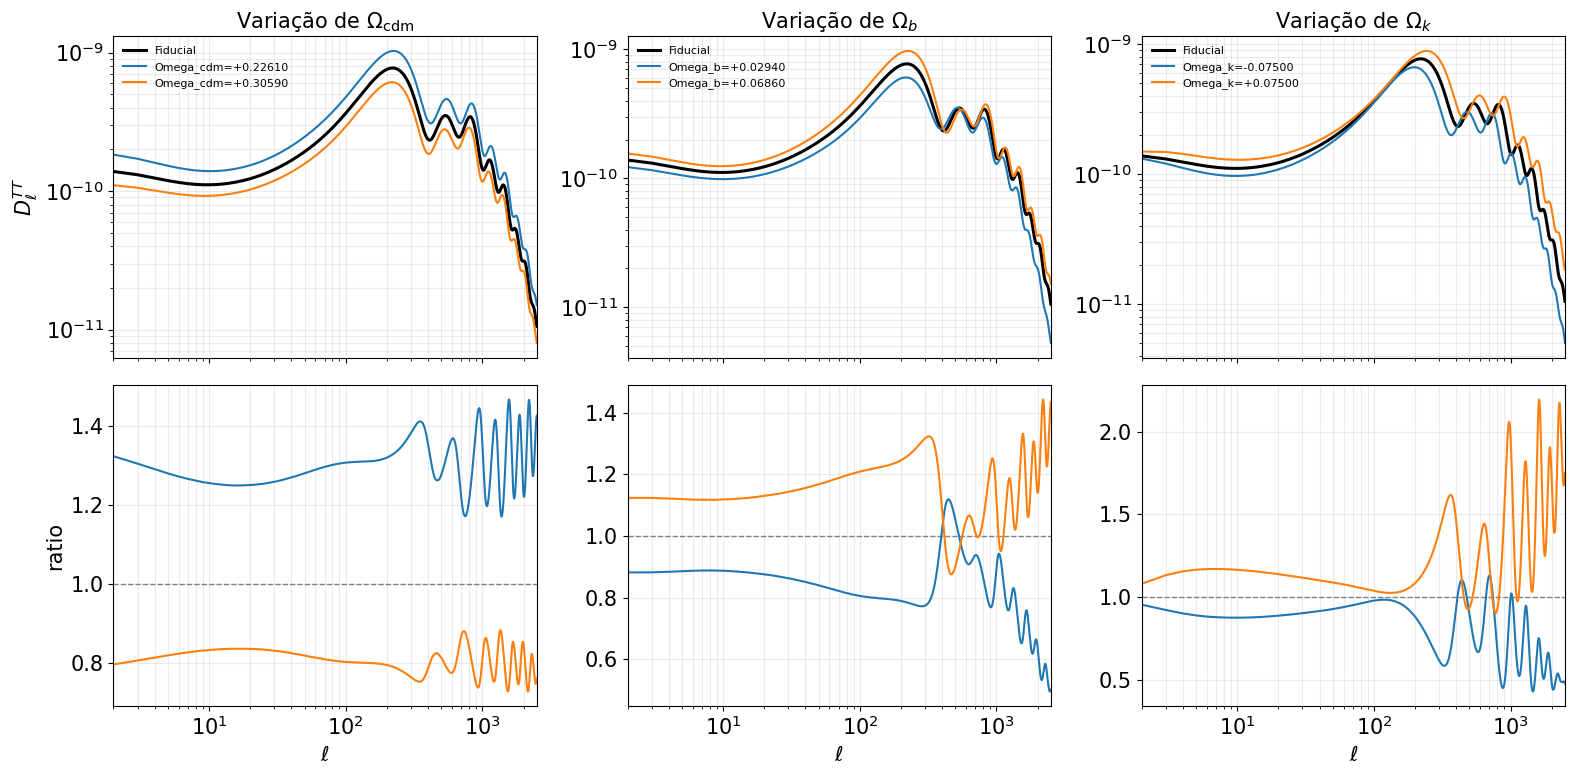

In [11]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

# ==============================================
# 1. Função base
# ==============================================
def build_baseline_params(sig8_ref, ns_ref, h_ref, Om_ref, Ob_ref, P_k_max_h_Mpc, k_per_decade):
    return {
        'modes'  : 's',
        'output' : 'tCl, pCl, lCl',
        'lensing': 'yes',
        'l_max_scalars': 3000,
        'Omega_Lambda': 0,
        'w0_fld'      : '-1.',
        'wa_fld'      : '0.0',
        'sigma8': sig8_ref,
        'n_s'   : ns_ref,
        'background_verbose'   : 0,
        'perturbations_verbose': 0,
        'gauge'                : 'Synchronous',
        'h'        : h_ref,
        'Omega_b'  : Ob_ref,
        'Omega_cdm': Om_ref - Ob_ref,
        'Omega_k'  : 0.0
    }

# ==============================================
# 2. Cria grade com ±10% para cada parâmetro
# ==============================================
def build_cosmology_grid(base):
    ocdm_fid = base['Omega_cdm']
    ob_fid   = base['Omega_b']
    ok_fid   = base['Omega_k']
    ocdm_values = [0.85*ocdm_fid, ocdm_fid, 1.15*ocdm_fid]
    ob_values   = [0.6*ob_fid,   ob_fid,   1.4*ob_fid]
    ok_values   = [-0.075, 0.0, +0.075]

    grid = {}
    for oc in ocdm_values:
        for ob in ob_values:
            for ok in ok_values:
                p = dict(base)
                p['Omega_cdm'] = oc
                p['Omega_b']   = ob
                p['Omega_k']   = ok
                name = f"oc{oc:.5f}_ob{ob:.5f}_ok{ok:+.4f}"
                grid[name] = p
    return grid

# ==============================================
# 3. Roda CLASS e coleta Cl_TT
# ==============================================
def compute_TT_cls(cosmo_dict, lmax_out=2500):
    results = {}
    for name, pars in cosmo_dict.items():
        cosmo = Class()
        pars['l_max_scalars'] = lmax_out
        cosmo.set(pars)
        cosmo.compute()
        cl = cosmo.lensed_cl(lmax_out)
        ell = np.array(cl['ell'])
        clTT = np.array(cl['tt'])
        results[name] = (ell, clTT)
        cosmo.struct_cleanup()
        cosmo.empty()
    return results

# ==============================================
# 4. Subplots por parâmetro com ratios
# ==============================================
def plot_TT_subplots_by_param(tt_map, cosmo_dict, base_params, use_Dl=True, lmin_plot=2, lmax_plot=None):
    def nearly(a, b): return abs(a - b) < 1e-10

    # Achar fiducial
    fid_name = next(n for n, p in cosmo_dict.items()
                    if nearly(p['Omega_cdm'], base_params['Omega_cdm'])
                    and nearly(p['Omega_b'], base_params['Omega_b'])
                    and nearly(p['Omega_k'], base_params['Omega_k']))
    ell_fid, cl_fid = tt_map[fid_name]
    mask = (ell_fid >= lmin_plot)
    if lmax_plot: mask &= (ell_fid <= lmax_plot)
    ell_ref = ell_fid[mask]
    Dl_fid = ell_ref*(ell_ref+1)*cl_fid[mask]/(2*np.pi) if use_Dl else cl_fid[mask]

    params = ['Omega_cdm', 'Omega_b', 'Omega_k']
    titles = [r'Variação de $\Omega_{\rm cdm}$',
              r'Variação de $\Omega_b$',
              r'Variação de $\Omega_k$']

    fig, axs = plt.subplots(2, 3, figsize=(16,8), sharex='col')
    for j, key in enumerate(params):
        # Subset mantendo os outros fixos
        subset = {n:p for n,p in cosmo_dict.items()
                  if all((k==key) or nearly(p[k], base_params[k]) for k in params)}

        ax_top, ax_bot = axs[0,j], axs[1,j]
        ax_top.plot(ell_ref, Dl_fid, lw=2.2, label="Fiducial", color='black')
        ax_bot.axhline(1.0, ls='--', lw=1, color='gray')

        for name, pars in sorted(subset.items(), key=lambda x: x[1][key]):
            if name == fid_name: continue
            ell, cl = tt_map[name]
            spec = np.interp(ell_ref, ell, cl)
            Dl = ell_ref*(ell_ref+1)*spec/(2*np.pi) if use_Dl else spec
            ratio = Dl / Dl_fid
            label = f"{key}={pars[key]:+.5f}"
            ax_top.plot(ell_ref, Dl, lw=1.5, label=label)
            ax_bot.plot(ell_ref, ratio, lw=1.5)

        ax_top.set_xscale('log'); ax_top.set_yscale('log')
        ax_bot.set_xscale('log')
        ax_top.set_title(titles[j])
        if j==0:
            ax_top.set_ylabel(r"$D_\ell^{TT}$")
            ax_bot.set_ylabel("ratio")
        ax_bot.set_xlabel(r"$\ell$")
        ax_top.grid(alpha=0.25, which='both')
        ax_bot.grid(alpha=0.25, which='both')
        ax_top.legend(fontsize=8, frameon=False)
        ax_bot.set_xlim(ell_ref.min(), ell_ref.max())

    plt.tight_layout()
    plt.show()

# ==============================================
# 5. Exemplo de uso completo
# ==============================================
# valores exemplo (substitua pelos seus reais)
sig8_ref = 0.83
ns_ref   = 0.965
h_ref    = 0.674
Om_ref   = 0.315
Ob_ref   = 0.049
P_k_max_h_Mpc = 10.0
k_per_decade  = 20

base = build_baseline_params(sig8_ref, ns_ref, h_ref, Om_ref, Ob_ref, P_k_max_h_Mpc, k_per_decade)
cosmo_dict = build_cosmology_grid(base)
tt_map = compute_TT_cls(cosmo_dict, lmax_out=2500)

# Gera os subplots (espectro + ratio)
plot_TT_subplots_by_param(tt_map, cosmo_dict, base, use_Dl=True, lmin_plot=2, lmax_plot=2500)


# Efeitos das variações cosmológicas no espectro de temperatura do CMB

## 🔹 Variação de $\Omega_{\mathrm{cdm}}$ — Matéria escura fria

Ao variar **$\Omega_{\mathrm{cdm}}$**, alteramos a **profundidade do poço de potencial gravitacional** durante a era de acoplamento fóton–bárion.  
Uma maior densidade de matéria escura:

- **Aumenta a gravidade** que confina o fluido acoplado, amplificando as oscilações iniciais.  
- **Adia a igualdade matéria–radiação**, modificando a escala de som e a altura relativa dos picos.  
- Como resultado, **todos os picos e vales são deslocados e reescalados**, pois a oscilação acústica responde ao potencial gravitacional mais profundo.  
- Para **$\Omega_{\mathrm{cdm}}$ menor**, o poço é raso e os picos são suavizados (menor contraste);  
  para **$\Omega_{\mathrm{cdm}}$ maior**, os picos são mais acentuados e deslocados para **ℓ maiores** (ângulos menores).

Matematicamente, o momento da igualdade matéria–radiação é dado por:

$$
a_{eq} = \frac{\Omega_{r,0}}{\Omega_{m,0}},
$$

de modo que um aumento em $\Omega_{\mathrm{cdm}}$ reduz $a_{eq}$ e aumenta o número de oscilações acústicas antes do desacoplamento.  
O tamanho do horizonte sonoro $r_s$ também depende fracamente de $\Omega_m h^2$ e $\Omega_b h^2$, afetando a escala angular dos picos via

$
\ell_A \simeq \pi \frac{D_A(z_*)}{r_s(z_*)},
$

onde $D_A(z_*)$ é a distância angular até a superfície de desacoplamento.  

---

## 🔹 Variação de $\Omega_{\mathrm{b}}$ — Matéria bariônica

A variação de **$\Omega_{\mathrm{b}}$** atua sobre a **inércia do fluido fóton–bárion**:

- Os **bárions aumentam a massa efetiva do plasma**, intensificando a compressão das ondas acústicas (picos ímpares, correspondentes a compressões) e reduzindo as rarefações (picos pares).  
- Assim, **aumentar $\Omega_{\mathrm{b}}$** realça o **primeiro pico** e suprime o **segundo**, produzindo uma modulação alternada nos picos subsequentes.  
- **Diminuir $\Omega_{\mathrm{b}}$** faz o oposto: picos mais uniformes e menor contraste entre pares e ímpares.

A equação de movimento do modo acústico do fluido acoplado é:

$
\ddot{\delta}_\gamma + c_s^2 k^2 \delta_\gamma = -\frac{k^2}{3} \Psi,
$

com a velocidade do som dada por

$
c_s = \frac{1}{\sqrt{3(1 + R)}}, \quad R \equiv \frac{3\rho_b}{4\rho_\gamma}.
$

Portanto, ao aumentar $R$ (via maior $\Omega_b$), o som se propaga mais lentamente, modificando a fase das oscilações e o contraste compressão–rarefação.

---

## 🔹 Variação de $\Omega_{\mathrm{k}}$ — Curvatura espacial

A curvatura espacial **reprojeta** o padrão angular do CMB:

- Em um universo **aberto ($\Omega_{\mathrm{k}}$ > 0)**, a geometria hiperbólica **aumenta as distâncias angulares**, deslocando os picos para **ℓ menores** (ângulos maiores).  
- Em um universo **fechado ($\Omega_{\mathrm{k}}$ < 0)**, as distâncias são encurtadas, e os picos se movem para **ℓ maiores** (ângulos menores).  
- A amplitude global muda pouco, mas o **posicionamento dos picos acústicos** sofre deslocamento horizontal perceptível.

O deslocamento angular pode ser descrito por:

$
\ell_A = \pi \frac{D_A(z_*)}{r_s(z_*)},
$

onde a distância angular depende da curvatura:

$
D_A(z) = \frac{1}{(1+z)H_0\sqrt{|\Omega_k|}} S_k \left( \sqrt{|\Omega_k|} \int_0^z \frac{dz'}{E(z')} \right),
$

com

$
S_k(x) =
\begin{cases}
\sin(x), & \Omega_k < 0 \\
x, & \Omega_k = 0 \\
\sinh(x), & \Omega_k > 0
\end{cases}
$

e $E(z) = H(z)/H_0$.  
Assim, a curvatura atua como uma lente geométrica, esticando ou comprimindo o espectro angular.

---

## 🧭 Resumo

| Parâmetro | Efeito principal | Comportamento dos picos | Relação matemática |
|------------|-----------------|--------------------------|--------------------|
| **$\Omega_{\mathrm{cdm}}$** | Profundidade do potencial gravitacional | Amplifica ou suaviza todos os picos | $a_{eq} = \Omega_r / \Omega_m$, $\ell_A \propto D_A / r_s$ |
| **$\Omega_{\mathrm{b}}$** | Inércia do fluido fóton–bárion | Alterna alturas (ímpares ↑, pares ↓) | $c_s = [3(1+R)]^{-1/2}$ |
| **$\Omega_{\mathrm{k}}$** | Geometria do espaço | Desloca picos em ℓ (ângulos aparentes) | $D_A(z) \propto S_k\left(\int \frac{dz^{'}}{E(z^{'})}\right)$ |

---

/home/gbrando/anaconda3/envs/class/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars
posx and posy should be finite values
posx and posy should be finite values


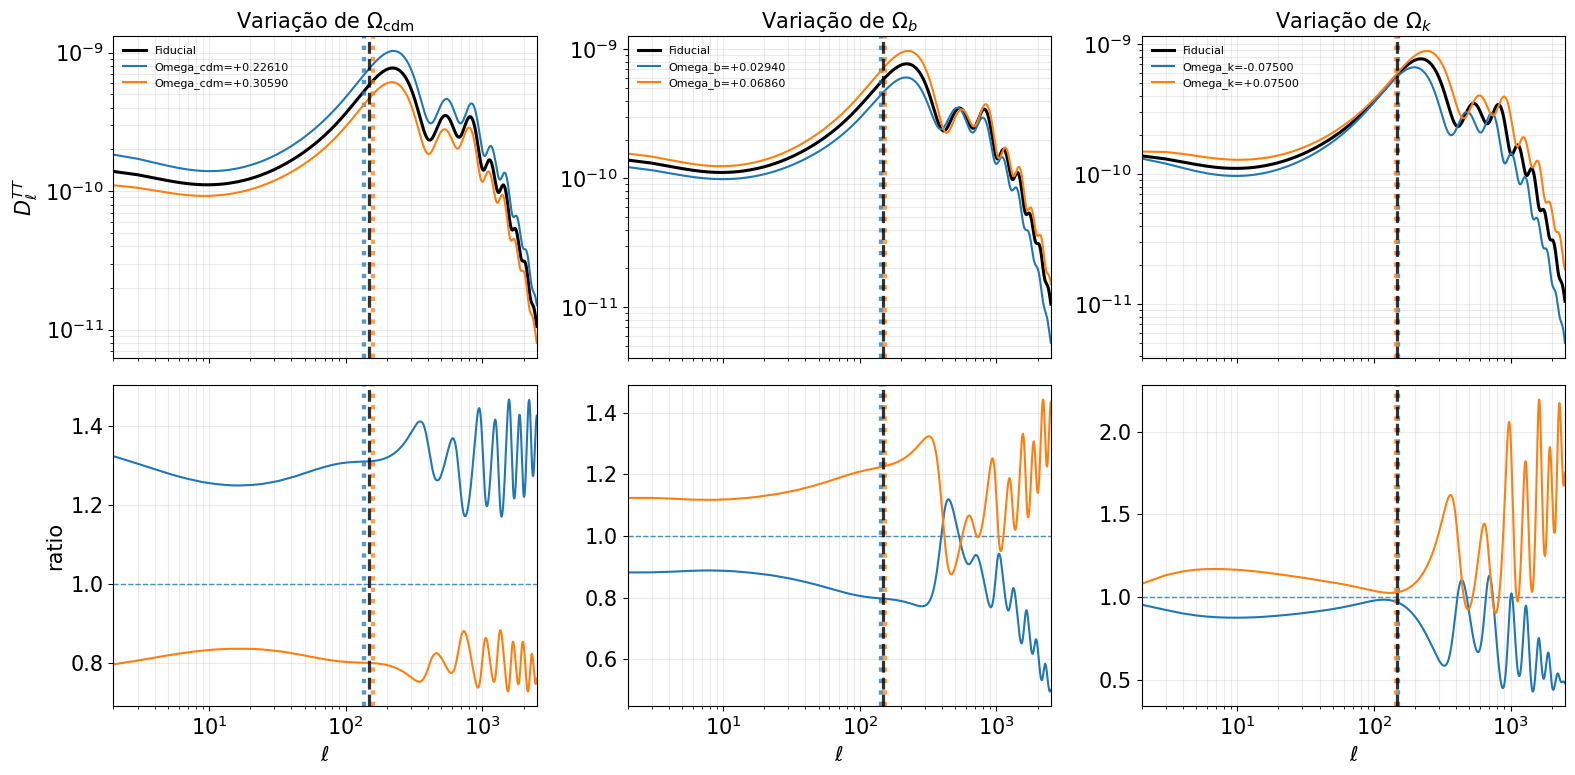

ℓ_eq (fiducial) ≈ 148.0


In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ===== Helper geral: k_eq e ell_eq A PARTIR DE UM DICIONÁRIO DE PARÂMETROS =====
def compute_keq_and_leq_from_params(pars, z_star=1090.0, Tcmb=2.7255, Neff=3.046):
    """
    Dado 'pars' com chaves {'h','Omega_b','Omega_cdm','Omega_k'}:
      retorna (k_eq [Mpc^-1], ell_eq [adim], z_eq)
    Assume fechamento com w = -1: Omega_L = 1 - Omega_m - Omega_k - Omega_r.
    """
    h        = float(pars['h'])
    Omega_b  = float(pars['Omega_b'])
    Omega_c  = float(pars['Omega_cdm'])
    Omega_k  = float(pars.get('Omega_k', 0.0))
    Omega_m  = Omega_b + Omega_c

    # radiação hoje
    Omega_gamma_h2 = 2.469e-5 * (Tcmb / 2.7255)**4
    Omega_r_h2     = Omega_gamma_h2 * (1.0 + 0.2271 * Neff)
    Omega_r        = Omega_r_h2 / (h * h)

    # fechar com w=-1
    Omega_L = 1.0 - Omega_m - Omega_k - Omega_r

    # igualdade & k_eq
    z_eq = Omega_m / Omega_r - 1.0            # a_eq = 1/(1+z_eq)
    k_eq = 0.0746 * (Omega_m * h * h)         # Mpc^-1   (Eisenstein & Hu)

    # distância comóvel até z*
    def E(z):
        return math.sqrt(Omega_r * (1.0 + z)**4 +
                         Omega_m * (1.0 + z)**3 +
                         Omega_k * (1.0 + z)**2 +
                         Omega_L)

    zs = np.linspace(0.0, z_star, 100000)     # 1e5 amostras = rápido e estável
    chi_star = (2997.92458 / h) * np.trapz(1.0 / np.vectorize(E)(zs), zs)  # Mpc

    ell_eq = k_eq * chi_star
    return k_eq, ell_eq, z_eq

# ===== Plot: agora desenha ell_eq PARA CADA CURVA (por coluna) =====
def plot_TT_subplots_by_param(tt_map, cosmo_dict, base_params,
                              use_Dl=True, lmin_plot=2, lmax_plot=None,
                              figsize=(16,8), z_star=1090.0, Tcmb=2.7255, Neff=3.046,
                              draw_per_curve_ell_eq=True, draw_fiducial_ell_eq=True,
                              ell_eq_ls=':', ell_eq_lw=3.1, ell_eq_alpha=0.75,
                              ell_eq_fid_ls='--', ell_eq_fid_color='black', ell_eq_fid_lw=2.3,
                              annotate=False):
    def nearly(a, b, tol=5e-10): return abs(a - b) < tol

    # Achar fiducial
    fid_candidates = [n for n, p in cosmo_dict.items()
                      if nearly(p['Omega_cdm'], base_params['Omega_cdm'])
                      and nearly(p['Omega_b'],   base_params['Omega_b'])
                      and nearly(p['Omega_k'],   base_params['Omega_k'])]
    fid_name = fid_candidates[0]
    ell_fid, cl_fid = tt_map[fid_name]
    mask = (ell_fid >= lmin_plot)
    if lmax_plot is not None:
        mask &= (ell_fid <= lmax_plot)
    ell_ref = ell_fid[mask]
    Dl_fid = ell_ref*(ell_ref+1.0)*cl_fid[mask]/(2.0*np.pi) if use_Dl else cl_fid[mask]

    # ℓ_eq do fiducial
    _, ell_eq_fid, _ = compute_keq_and_leq_from_params(base_params, z_star=z_star, Tcmb=Tcmb, Neff=Neff)

    params = ['Omega_cdm','Omega_b','Omega_k']
    titles = [r'Variação de $\Omega_{\rm cdm}$',
              r'Variação de $\Omega_b$',
              r'Variação de $\Omega_k$']

    fig, axs = plt.subplots(2, 3, figsize=figsize, sharex='col')
    for j, key in enumerate(params):
        subset = {n: p for n, p in cosmo_dict.items()
                  if all((k == key) or nearly(p[k], base_params[k]) for k in params)}

        ax_top, ax_bot = axs[0, j], axs[1, j]
        ax_top.plot(ell_ref, Dl_fid, lw=2.2, color='black', label="Fiducial")
        ax_bot.axhline(1.0, ls='--', lw=1, alpha=0.8)

        # Curvas + suas ℓ_eq
        for name, pars in sorted(subset.items(), key=lambda x: x[1][key]):
            if name == fid_name: continue
            ell, cl = tt_map[name]
            spec = np.interp(ell_ref, ell, cl)
            Dl = ell_ref*(ell_ref+1.0)*spec/(2.0*np.pi) if use_Dl else spec
            ratio = Dl / Dl_fid

            line_curva, = ax_top.plot(ell_ref, Dl, lw=1.5, label=f"{key}={pars[key]:+.5f}")
            ax_bot.plot(ell_ref, ratio, lw=1.5, color=line_curva.get_color())

            if draw_per_curve_ell_eq:
                _, ell_eq_curve, _ = compute_keq_and_leq_from_params(pars, z_star=z_star, Tcmb=Tcmb, Neff=Neff)
                c = line_curva.get_color()
                for ax in (ax_top, ax_bot):
                    ax.axvline(ell_eq_curve, ls=ell_eq_ls, lw=ell_eq_lw, alpha=ell_eq_alpha, color=c)

        # ℓ_eq fiducial (preto)
        if draw_fiducial_ell_eq and np.isfinite(ell_eq_fid):
            for ax in (ax_top, ax_bot):
                ax.axvline(ell_eq_fid, ls=ell_eq_fid_ls, color=ell_eq_fid_color,
                           lw=ell_eq_fid_lw, alpha=0.8)
            if annotate and j == 0:
                y0, y1 = ax_top.get_ylim()
                y_text = y0 * (y1 / y0)**0.15
                ax_top.text(ell_eq_fid*1.02, y_text, r'$\ell_{\rm eq}^{\rm fid}$',
                            rotation=90, va='bottom', ha='left', fontsize=9, color='black')

        ax_top.set_xscale('log'); ax_top.set_yscale('log')
        ax_bot.set_xscale('log')
        ax_top.set_title(titles[j])
        if j == 0:
            ax_top.set_ylabel(r"$D_\ell^{TT}$" if use_Dl else r"$C_\ell^{TT}$")
            ax_bot.set_ylabel("ratio")
        ax_bot.set_xlabel(r"$\ell$")
        ax_top.grid(alpha=0.25, which='both')
        ax_bot.grid(alpha=0.25, which='both')
        ax_top.legend(fontsize=8, frameon=False)
        ax_bot.set_xlim(ell_ref.min(), ell_ref.max())

    plt.tight_layout()
    plt.show()
    return ell_eq_fid


ell_eq_fid = plot_TT_subplots_by_param(
    tt_map, cosmo_dict, base,
    use_Dl=True, lmin_plot=2, lmax_plot=2500,
    draw_per_curve_ell_eq=True,    # ℓ_eq para cada curva
    draw_fiducial_ell_eq=True,     # ℓ_eq fiducial (preto)
    annotate=True
)
print(f"ℓ_eq (fiducial) ≈ {ell_eq_fid:.1f}")

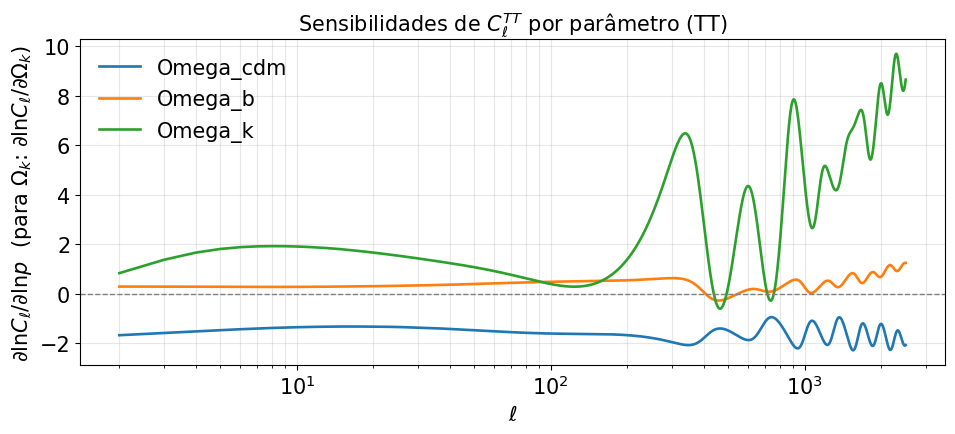

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def _nearly(a, b, tol=1e-12): return abs(float(a)-float(b)) < tol

def _find_fid_name(cosmo_dict, base):
    for name, p in cosmo_dict.items():
        if (_nearly(p['Omega_cdm'], base['Omega_cdm']) and
            _nearly(p['Omega_b'],   base['Omega_b'])   and
            _nearly(p['Omega_k'],   base['Omega_k'])):
            return name
    raise RuntimeError("Fiducial não encontrado em cosmo_dict.")

def compute_sensitivities_only(tt_map, cosmo_dict, base, use_Dl=False, lmin=2, lmax=None):
    """
    Retorna:
      ell_ref,
      sens_dict:
        - 'Omega_cdm' : d ln C_l / d ln Omega_cdm
        - 'Omega_b'   : d ln C_l / d ln Omega_b
        - 'Omega_k'   : d ln C_l / d Omega_k   (linear em p)
    """
    params = ['Omega_cdm','Omega_b','Omega_k']
    mode   = {'Omega_cdm':'log', 'Omega_b':'log', 'Omega_k':'linear'}

    fid_name = _find_fid_name(cosmo_dict, base)
    ell_fid, cl_fid = tt_map[fid_name]
    mask = (ell_fid >= lmin)
    if lmax is not None: mask &= (ell_fid <= lmax)
    ell_ref = np.asarray(ell_fid[mask])
    Cl_fid  = np.interp(ell_ref, ell_fid, cl_fid)
    if use_Dl:
        Cl_fid = ell_ref*(ell_ref+1)*Cl_fid/(2*np.pi)

    sens = {}

    for key in params:
        # junte todas as curvas variando só 'key'
        trip = []
        for name, pars in cosmo_dict.items():
            if all((k==key) or _nearly(pars[k], base[k]) for k in params):
                trip.append((float(pars[key]), name))
        if len(trip) < 2:
            print(f"[aviso] Poucos pontos para {key}; não dá para derivar.")
            continue
        trip.sort(key=lambda t: t[0])

        # ache o índice do fiducial (ou o mais próximo)
        p_vals = [t[0] for t in trip]
        try:
            i0 = p_vals.index(float(base[key]))
        except ValueError:
            i0 = int(np.argmin([abs(v-base[key]) for v in p_vals]))

        # escolha pares para derivada (central se possível; senão, um lado)
        if 0 < i0 < len(trip)-1:
            i_minus, i_plus = i0-1, i0+1
        elif i0 == 0:
            i_minus, i_plus = 0, 1
            print(f"[nota] Usando derivada forward (1-lado) para {key}.")
        else:
            i_minus, i_plus = len(trip)-2, len(trip)-1
            print(f"[nota] Usando derivada backward (1-lado) para {key}.")

        p_minus, name_m = trip[i_minus]
        p_plus,  name_p = trip[i_plus]

        # espectros
        ell_m, cl_m = tt_map[name_m]
        ell_p, cl_p = tt_map[name_p]
        Cl_m = np.interp(ell_ref, ell_m, cl_m)
        Cl_p = np.interp(ell_ref, ell_p, cl_p)
        if use_Dl:
            Cl_m = ell_ref*(ell_ref+1)*Cl_m/(2*np.pi)
            Cl_p = ell_ref*(ell_ref+1)*Cl_p/(2*np.pi)

        # derivadas
        if mode[key] == 'log':
            # d ln C / d ln p  ≈ [ln C(p+) - ln C(p-)] / [ln p+ - ln p-]
            dlnC = np.log(np.clip(Cl_p, 1e-300, None)) - np.log(np.clip(Cl_m, 1e-300, None))
            dlnp = np.log(p_plus) - np.log(p_minus)
            S = dlnC / dlnp
        else:
            # 'linear' em p: d ln C / d p  ≈ [ln C(p+) - ln C(p-)] / (p+ - p-)
            dlnC = np.log(np.clip(Cl_p, 1e-300, None)) - np.log(np.clip(Cl_m, 1e-300, None))
            dp   = (p_plus - p_minus)
            S = dlnC / dp

        sens[key] = S

    return ell_ref, sens

def plot_only_sensitivities(ell, sens, use_Dl=False, title_suffix=""):
    plt.figure(figsize=(9.8,4.6))
    for key in ['Omega_cdm','Omega_b','Omega_k']:
        if key in sens:
            plt.semilogx(ell, sens[key], lw=1.9, label=key)
    plt.axhline(0, color='gray', lw=1, ls='--')
    ylab = r'$\partial\ln C_\ell / \partial \ln p$' if not use_Dl else r'$\partial\ln D_\ell / \partial \ln p$'
    # esclareça Omega_k:
    ylab += r'  (para $\Omega_k$: $\partial\ln C_\ell/\partial \Omega_k$)'
    plt.xlabel(r'$\ell$'); plt.ylabel(ylab)
    plt.title(f"Sensibilidades de $C_\\ell^{{TT}}$ por parâmetro{title_suffix}")
    plt.grid(alpha=0.3, which='both'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

# ===== Executar =====
ell_ref, sens_dict = compute_sensitivities_only(
    tt_map, cosmo_dict, base, use_Dl=False, lmin=2, lmax=2500
)
plot_only_sensitivities(ell_ref, sens_dict, use_Dl=False, title_suffix=" (TT)")


### Interpretação das sensibilidades de \( C_\ell^{TT} \)

O gráfico mostra como o espectro de temperatura da CMB $( C_\ell^{TT} $) reage a pequenas variações em três parâmetros cosmológicos:
$
S_p(\ell) \equiv \frac{\partial \ln C_\ell}{\partial \ln p}
\quad \text{ou} \quad
\frac{\partial \ln C_\ell}{\partial p}
$

---

#### 🔵 $ \Omega_{\mathrm{cdm}}$  —  Matéria escura fria
- A curva azul mostra que $ C_\ell^{TT} $ **diminui** quando aumentamos $\Omega_{\mathrm{cdm}}$.
- Fisicamente, mais matéria escura **antecipa a igualdade matéria-radiação**, reduzindo a importância dos efeitos de radiação.
- Isso desloca as oscilações acústicas e reduz a potência nas escalas intermediárias.
- O sinal é negativo em quase todo o espectro — maior densidade de matéria escurece o CMB.

---

#### 🟠 $ \Omega_b$  —  Matéria bariônica
- A curva laranja é mais suave: o espectro é **menos sensível** a $\Omega_b$.
- Variações em $\Omega_b$ alteram a **razão entre compressões e rarefações acústicas**, modulando levemente as alturas ímpares/par.
- O efeito é pequeno em módulo $(|S|<0.5$), indicando baixa sensibilidade global.

---

#### 🟢 $ \Omega_k $  —  Curvatura espacial
- A curva verde mostra grande amplitude: $C_\ell^{TT}$ é **altamente sensível** à curvatura.
- A curvatura altera a **distância angular até o último espalhamento**, deslocando a posição dos picos acústicos:
  - $ \Omega_k < 0 $ (Universo fechado) → picos deslocam para **$\ell$ maiores**.
  - $ \Omega_k > 0 $ (aberto) → picos para **$\ell$ menores**.
- Isso produz oscilações fortes e um gradiente grande em alta $\ell$.
- Em magnitude, é o **parâmetro mais influente** no $C_\ell^{TT}$ dentre os três mostrados.

---

**Resumo:**
- $ \Omega_k $ → controla a **geometria e escalas angulares** → maior sensibilidade.  
- $ \Omega_{\mathrm{cdm}} $ → afeta a **época da igualdade e a profundidade dos picos**.  
- $ \Omega_b $ → ajusta a **modulação fina das amplitudes acústicas**.


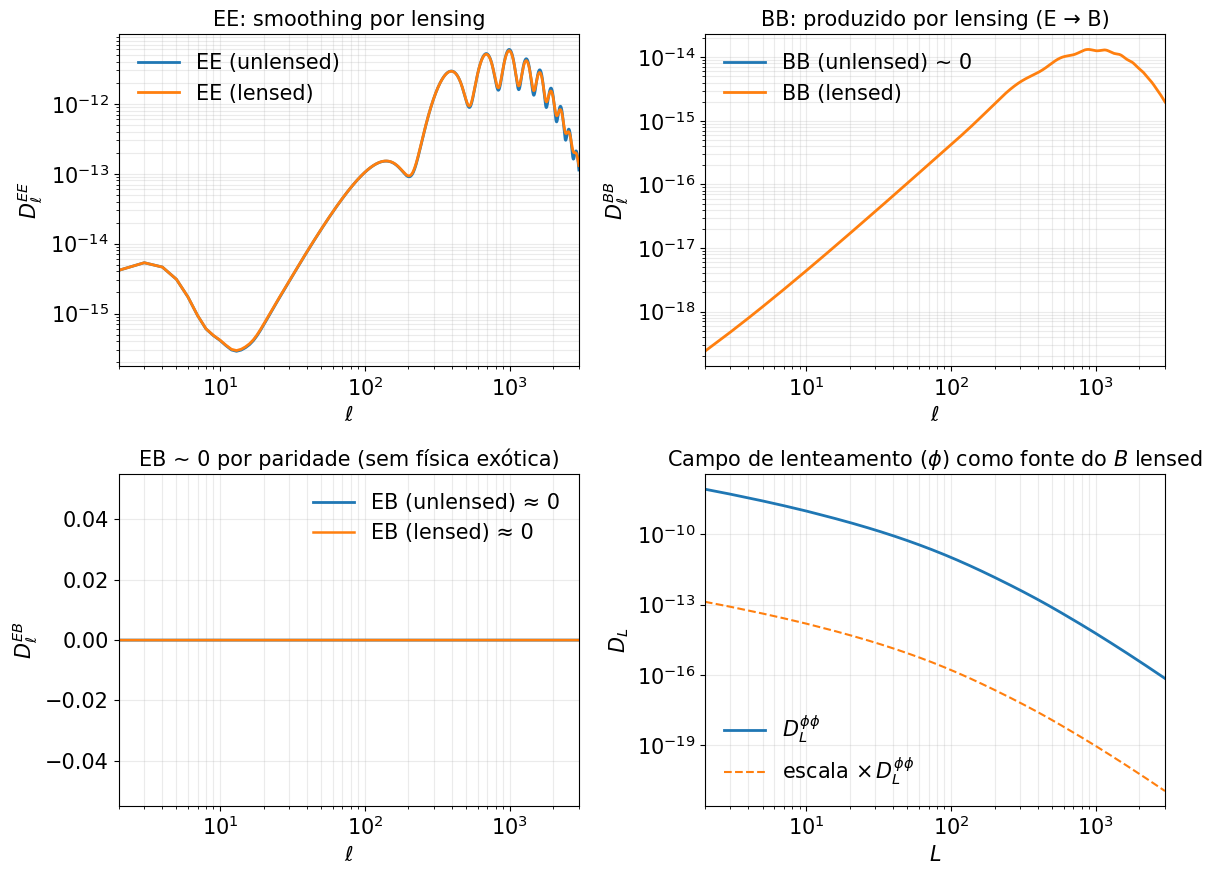

In [17]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

# ---------- Fiducial ----------
sig8_ref = 0.83
ns_ref   = 0.965
h_ref    = 0.674
Om_ref   = 0.315
Ob_ref   = 0.049

P_k_max_h_Mpc = 10.0
k_per_decade  = 20
lmax_out      = 3000

def build_fiducial_with_lensing():
    return {
        'modes'  : 's',                    # só escalares
        'output' : 'tCl, pCl, lCl',        # lCl => phi-phi (lensing potential)
        'lensing': 'yes',                  # precisamos do potencial de lenteamento
        'l_max_scalars': lmax_out,

        'Omega_Lambda': 0, 'w0_fld': '-1.', 'wa_fld': '0.0',
        'sigma8': sig8_ref, 'n_s': ns_ref, 'gauge': 'Synchronous',
        'background_verbose': 0, 'perturbations_verbose': 0,

        'h': h_ref, 'Omega_b': Ob_ref, 'Omega_cdm': Om_ref - Ob_ref,
        'Omega_k': 0.0,

    }

def get_unlensed_and_lensed_with_phi():
    pars = build_fiducial_with_lensing()
    cosmo = Class(); cosmo.set(pars); cosmo.compute()

    # Unlensed (primordial + linear evolution)
    raw  = cosmo.raw_cl(lmax_out)
    ell  = np.asarray(raw['ell'])
    cl_ee_unl = np.asarray(raw['ee'])
    cl_bb_unl = np.asarray(raw['bb']) if 'bb' in raw else np.zeros_like(ell)  # ~0 para escalares
    cl_eb_unl = np.zeros_like(ell)  # EB ~ 0 por paridade

    # Lensed (pós-remoção do efeito de lensing)
    lns  = cosmo.lensed_cl(lmax_out)
    cl_ee_len = np.asarray(lns['ee'])
    cl_bb_len = np.asarray(lns['bb'])
    cl_eb_len = np.zeros_like(ell)  # lensing padrão não gera EB médio

    # Potencial de lenteamento
    # CLASS guarda 'pp' = C_L^{phi phi} nos 'raw_cl' quando output tem lCl
    cl_pp = np.asarray(raw['pp'])  # espectro do potencial de lenteamento

    cosmo.struct_cleanup(); cosmo.empty()
    return ell, cl_ee_unl, cl_ee_len, cl_bb_unl, cl_bb_len, cl_eb_unl, cl_eb_len, cl_pp

def Dl(ell, cl):  # D_ell = ell(ell+1) C_ell / (2π)
    return ell*(ell+1.0)*cl/(2.0*np.pi)

# ---------- Rodar ----------
ell, clEE_u, clEE_l, clBB_u, clBB_l, clEB_u, clEB_l, clPP = get_unlensed_and_lensed_with_phi()


# ---------- 4) Plot (com ell >= 2) ----------
mask = ell >= 2
ell = ell[mask]
clEE_u = clEE_u[mask]; clEE_l = clEE_l[mask]
clBB_u = clBB_u[mask]; clBB_l = clBB_l[mask]
clEB_u = clEB_u[mask]; clEB_l = clEB_l[mask]
clPP   = clPP[mask]

fig, axs = plt.subplots(2, 2, figsize=(12,9))

# (1) EE: unlensed vs lensed
ax = axs[0,0]
ax.plot(ell, Dl(ell, clEE_u), lw=2, label='EE (unlensed)')
ax.plot(ell, Dl(ell, clEE_l), lw=2, label='EE (lensed)')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(2, 3000)
ax.set_xlabel(r'$\ell$'); ax.set_ylabel(r'$D_\ell^{EE}$')
ax.set_title('EE: smoothing por lensing')
ax.grid(alpha=0.25, which='both'); ax.legend(frameon=False)

# (2) BB: unlensed vs lensed
ax = axs[0,1]
ax.plot(ell, Dl(ell, clBB_u), lw=2, label='BB (unlensed) ~ 0')
ax.plot(ell, Dl(ell, clBB_l), lw=2, label='BB (lensed)')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(2, 3000)
ax.set_xlabel(r'$\ell$'); ax.set_ylabel(r'$D_\ell^{BB}$')
ax.set_title('BB: produzido por lensing (E → B)')
ax.grid(alpha=0.25, which='both'); ax.legend(frameon=False)

# (3) EB ~ 0 (unlensed e lensed)
ax = axs[1,0]
ax.plot(ell, Dl(ell, clEB_u), lw=2, label='EB (unlensed) ≈ 0')
ax.plot(ell, Dl(ell, clEB_l), lw=1.8, label='EB (lensed) ≈ 0')
ax.set_xscale('log')
ax.set_xlim(2, 3000)
ax.set_xlabel(r'$\ell$'); ax.set_ylabel(r'$D_\ell^{EB}$')
ax.set_title('EB ~ 0 por paridade (sem física exótica)')
ax.grid(alpha=0.25, which='both'); ax.legend(frameon=False)

# (4) Potencial de lenteamento
ax = axs[1,1]
L = ell
ax.plot(L, Dl(L, clPP), lw=2, label=r'$D_L^{\phi\phi}$')
scale = (Dl(ell, clBB_l)[(ell>100)&(ell<2000)].max() /
         Dl(L, clPP)[(L>10)&(L<500)].max())
ax.plot(L, scale*Dl(L, clPP), lw=1.5, ls='--', label=r'escala $\times\,D_L^{\phi\phi}$')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(2, 3000)
ax.set_xlabel(r'$L$'); ax.set_ylabel(r'$D_L$')
ax.set_title(r'Campo de lenteamento ($\phi$) como fonte do $B$ lensed')
ax.grid(alpha=0.25, which='both'); ax.legend(frameon=False)

plt.tight_layout()
plt.show()


## Origem física das anistropias e da polarização na CMB

A derivação inicial das **anistropias de temperatura** do fundo cósmico de micro-ondas (CMB) considera o **espalhamento elástico** entre fótons e bárions — em particular, o **espalhamento Thomson** (limite clássico do espalhamento Compton).  
Nesse regime, o fóton interage com elétrons quase livres, trocando **momento angular**, mas **sem trocar energia** de forma significativa, o que justifica tratá-lo como um acoplamento elástico dentro do fluido fóton–bárion.

No entanto, esse é apenas um **caso particular do espalhamento Compton**, que é o processo fundamental responsável pela interação entre radiação e matéria no plasma primordial.  
O **espalhamento Compton inelástico** permite pequenas trocas de energia entre fótons e elétrons, alterando o módulo do vetor de intensidade da onda eletromagnética.

Quando esse espalhamento ocorre em um campo de radiação **anisotrópico**, a intensidade da onda resultante decomposta no plano transversal (x–y) à direção de propagação (z) torna-se **diferente em cada direção**, ou seja:
$
|E_x| \neq |E_y|.
$
Essa diferença rompe a simetria de polarização e produz **polarização linear** da radiação.

É justamente esse mecanismo — o espalhamento Compton anisotrópico próximo à época do **último espalhamento** — que gera a **polarização linear observada na CMB**.  
Assim, a polarização é uma consequência direta das **anisotropias de quadrupolo** presentes no campo de radiação no momento em que os fótons se desacoplam do plasma.


In [19]:
# ======== obter z_reio e z_rec (com fallback) ========
# 1) tentar via parâmetros derivados do CLASS
z_reio = None
z_rec  = None
try:
    d = cosmo.get_current_derived_parameters(['z_reio','z_rec'])
    z_reio = float(d.get('z_reio', np.nan))
    z_rec  = float(d.get('z_rec',  np.nan))
    if not np.isfinite(z_reio): z_reio = None
    if not np.isfinite(z_rec):  z_rec  = None
except Exception:
    pass

# 2) fallback via picos de g(z) na tabela thermo
#    - reionização: maior pico para z <= 30
#    - recombinação: pico global (z ~ 1100)
if g is not None:
    # garanta arrays 1D
    z_arr = np.asarray(z).ravel()
    g_arr = np.asarray(g).ravel()

    # reionização (pico em z <= 30)
    if z_reio is None:
        m_re = (z_arr >= 0) & (z_arr <= 30) & np.isfinite(g_arr)
        if np.any(m_re):
            i = np.argmax(g_arr[m_re])
            z_reio = float(z_arr[m_re][i])

    # recombinação (pico global)
    if z_rec is None:
        m_all = np.isfinite(g_arr)
        i = np.argmax(g_arr[m_all])
        z_rec = float(z_arr[m_all][i])

# valores finais (com defaults seguros se algo falhar)
if z_reio is None: z_reio = 8.0   # típico
if z_rec  is None: z_rec  = 1090. # típico

print(f"z_reio ≈ {z_reio:.3f}   z_rec ≈ {z_rec:.1f}")


z_reio ≈ 7.882   z_rec ≈ 1089.0


tau_reio (CLASS) ≈ 0.056
coluna z: z
coluna kappa: kappa' [Mpc^-1]
coluna g: g [Mpc^-1]
coluna x_e: x_e


/home/gbrando/anaconda3/envs/class/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/gbrando/anaconda3/envs/class/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/gbrando/anaconda3/envs/class/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


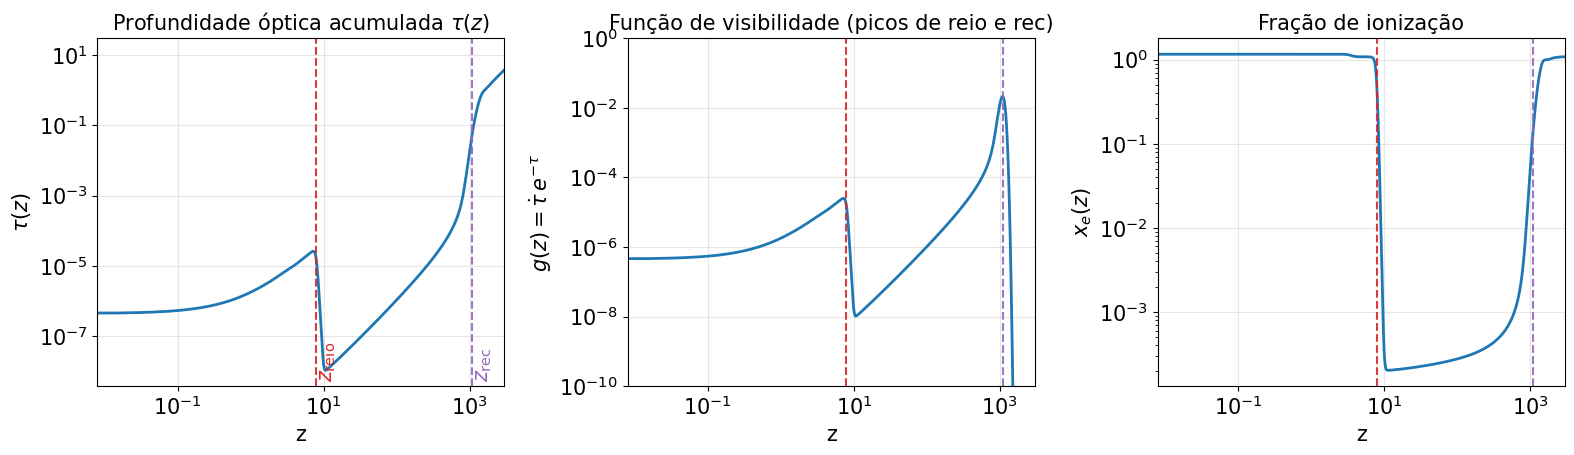

In [20]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt

# --------- Parâmetros (ajuste os seus) ----------
pars = {
    'modes':'s', 'output':'tCl, pCl, lCl', 'lensing':'yes', 'l_max_scalars':3000,
    'h':0.674, 'Omega_b':0.049, 'Omega_cdm':0.315-0.049, 'Omega_k':0.0,
    'Omega_Lambda':0, 'w0_fld':'-1.', 'wa_fld':'0.0',
    'n_s':0.965, 'sigma8':0.83, 'tau_reio':0.056,
    'background_verbose':0, 'perturbations_verbose':0
}

cosmo = Class(); cosmo.set(pars); cosmo.compute()
thermo = cosmo.get_thermodynamics()

# --- utilitário para achar colunas por substring (case-insensitive) ---
def pick_by_substr(d, include, exclude=()):
    include = [s.lower() for s in include]
    exclude = [s.lower() for s in exclude]
    for k in d.keys():
        kl = k.lower()
        if all(s in kl for s in include) and not any(s in kl for s in exclude):
            v = np.asarray(d[k], dtype=float)
            return k, v
    return None, None

# z
kz, z = pick_by_substr(thermo, ['z'])
if z is None:
    # algumas builds usam 'scale factor a' + 'conf. time [Mpc]'; mas normalmente há 'z'
    raise ValueError(f"Não encontrei coluna de z. Chaves disponíveis: {list(thermo.keys())}")

# kappa (tau)
kkappa, kappa = pick_by_substr(thermo, ['kappa'], exclude=['exp', 'prime', 'dkappa'])
if kappa is None:
    # reconstrói a partir de exp(-kappa), se existir
    kexp, exp_minus_kappa = pick_by_substr(thermo, ['exp(-kappa)'])
    if exp_minus_kappa is not None:
        kappa = -np.log(np.clip(exp_minus_kappa, 1e-300, 1.0))
        kkappa = kexp + " -> kappa"
    else:
        raise ValueError("Não encontrei 'kappa' nem 'exp(-kappa)' na tabela de termodinâmica.")

# g (visibility function)
kg, g = pick_by_substr(thermo, ['g'])
# filtrar falso-positivo: às vezes há 'g [Mpc^-1]' (ok), mas evite pegar 'dTb [K]' etc.
if kg is not None and ('g ' not in kg.lower() and not kg.lower().startswith('g')):
    # tentativa extra: procure exatamente 'g ' ou ' g['
    kg, g = pick_by_substr(thermo, ['g '])
if g is None:
    # tudo bem se não houver; só não plota
    pass

# x_e
kxe, xe = pick_by_substr(thermo, ['x_e'])
if xe is None:
    kxe, xe = pick_by_substr(thermo, ['xe'])

# tau_reio (derivado pelo CLASS)
tau_reio = cosmo.get_current_derived_parameters(['tau_reio'])['tau_reio']
print(f"tau_reio (CLASS) ≈ {tau_reio:.3f}")
print(f"coluna z: {kz}")
print(f"coluna kappa: {kkappa}")
print(f"coluna g: {kg}")
print(f"coluna x_e: {kxe}")

# ---------- Plots com z <= 30 ----------
mask = (z >= 0) & (z <= 5e3)
zplt = z[mask]
kapplt = kappa[mask]

fig, axs = plt.subplots(1, 3, figsize=(16,4.8))

# (1) τ(z)
ax = axs[0]
ax.loglog(zplt, kapplt, lw=2)
ax.axvline(z_reio, ls='--', lw=1.5, alpha=0.9, color='tab:red')
ax.axvline(z_rec,  ls='--', lw=1.5, alpha=0.9, color='tab:purple')
ax.text(z_reio*1.05, ax.get_ylim()[0]*1.3, r'$z_{\rm reio}$', rotation=90, color='tab:red', va='bottom', ha='left')
ax.text(z_rec*1.05,  ax.get_ylim()[0]*1.3, r'$z_{\rm rec}$',  rotation=90, color='tab:purple', va='bottom', ha='left')
ax.set_xlim(0, 3e3)
ax.set_xlabel('z')
ax.set_ylabel(r'$\tau(z)$')
ax.set_title(r'Profundidade óptica acumulada $\tau(z)$')
ax.grid(alpha=0.3)

# (2) g(z)
ax = axs[1]
if g is not None:
    ax.loglog(zplt, g[mask], lw=2)
    ax.axvline(z_reio, ls='--', lw=1.5, alpha=0.9, color='tab:red')
    ax.axvline(z_rec,  ls='--', lw=1.5, alpha=0.9, color='tab:purple')
    ax.set_xlim(0, 3e3); ax.set_ylim(bottom=1e-10, top=1e0)
    ax.set_xlabel('z'); ax.set_ylabel(r'$g(z)=\dot\tau\,e^{-\tau}$')
    ax.set_title('Função de visibilidade (picos de reio e rec)')
    ax.grid(alpha=0.3)
else:
    ax.text(0.5,0.5,'g(z) não disponível nesta build',ha='center',va='center',transform=ax.transAxes)

# (3) x_e(z)
ax = axs[2]
if xe is not None:
    ax.loglog(zplt, xe[mask], lw=2)
    ax.axvline(z_reio, ls='--', lw=1.5, alpha=0.9, color='tab:red')
    ax.axvline(z_rec,  ls='--', lw=1.5, alpha=0.9, color='tab:purple')
    ax.set_xlim(0, 3e3)
    ax.set_xlabel('z'); ax.set_ylabel(r'$x_e(z)$')
    ax.set_title('Fração de ionização')
    ax.grid(alpha=0.3)
else:
    ax.text(0.5,0.5,'x_e(z) não disponível nesta build',ha='center',va='center',transform=ax.transAxes)


plt.tight_layout(); plt.show()

cosmo.struct_cleanup(); cosmo.empty()


# Profundidade óptica, função de visibilidade e o “quão opaco” é o Universo

## 1) Profundidade óptica da reionização $ \tau_{\rm reio} $

A **profundidade óptica** mede a probabilidade cumulativa de um fóton do CMB sofrer **reespalhamento Thomson** entre certa época e hoje. Em tempo conforme $\eta$,

$\tau(\eta)\;=\;\int_{\eta}^{\eta_0}\! a(\tilde\eta)\,n_e(\tilde\eta)\,\sigma_T\;d\tilde\eta,$

onde $a$ é o fator de escala, $n_e$ a **densidade de elétrons livres**, e $\sigma_T$ a seção de choque de Thomson.  
A quantidade usada nas análises é a **profundidade óptica da reionização**,

$\tau_{\rm reio}\;\equiv\;\tau(\eta_{\rm re}) \;=\;\int_{\eta_{\rm re}}^{\eta_0}\! a\,n_e\,\sigma_T\,d\eta
\;=\;\int_0^{z_{\rm re}}\!\frac{c\;\sigma_T\;n_e(z)}{(1+z)\,H(z)}\,dz,$

isto é, a contribuição de $z=0$ até o início da reionização.

---

## 2) Função de visibilidade $ g $

A **função de visibilidade** é a densidade de probabilidade (por unidade de $\eta$) de um fóton sofrer **seu último espalhamento** em \(\eta\):

$g(\eta)\;\equiv\;\dot{\tau}(\eta)\,e^{-\tau(\eta)}
\;=\;a(\eta)\,n_e(\eta)\,\sigma_T\;e^{-\tau(\eta)}.$

Em termos de redshift,

$g(z)\;=\; \frac{c\,\sigma_T\,n_e(z)}{(1+z)\,H(z)}\;e^{-\tau(z)}.$

### Por que $g$) “mede” opacidade vs. transparência?

- O fator **$a\,n_e\,\sigma_T$** (ou $c\,\sigma_T\,n_e/[(1+z)H]$ em $z$) quantifica **o quão fácil é espalhar**: mais elétrons livres $\Rightarrow$ meio **mais opaco** (maior \(\dot\tau\)).  
- O fator **$e^{-\tau}$** é a **sobrevivência** até ali: se o caminho até $\eta$ já foi muito opaco $(\tau$ grande), poucos fótons chegam **sem ter espalhado antes** $\Rightarrow$ **probabilidade menor** de “último espalhamento” naquele instante.  

O produto captura exatamente a competição “**capacidade de espalhar agora**” × “**ter chegado até aqui sem espalhar**”.  
Por isso, $g$ tem **picos** quando o Universo está **brevemente opaco** (recombinação, reionização) e é **pequeno** nos longos intervalos transparentes.

---

## 3) Fração de elétrons livres $x_e$ entre recombinação e reionização

A fração de ionização é
$x_e(z)\;\equiv\;\frac{n_e(z)}{n_{\rm H}(z)}\quad(\text{aprox. por H})$,
ou, mais precisamente, o número de elétrons livres por átomo de hidrogênio (com correções por hélio).

- **Após a recombinação** $(z\sim 1100$), a maior parte dos elétrons combina com prótons formando H neutro: o Universo torna-se **quase transparente** ao CMB.  
- **Antes da reionização** $(z\sim 6\text{–}10$), $x_e$ permanece **muito pequeno, mas não exatamente zero** (há uma **ionização residual** típica $\sim 10^{-4}$).  
- **Durante a reionização**, fontes astrofísicas reionizam o meio: $x_e$ volta a $\sim 1$ (para H), aumentando $n_e$, o que gera um **pico largo em $g(z)$** e a **profundidade óptica** $\tau_{\rm reio}$ medida pelo bump de grande ângulo em $C_\ell^{EE}$.

> Em resumo: entre recombinação e reionização o Universo é **transparente** para o CMB (opacidade muito baixa), pois $x_e$ é **minúsculo** (mas não literalmente zero); isso explica o vale de $g(z)$ entre os dois picos.

/home/gbrando/anaconda3/envs/class/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


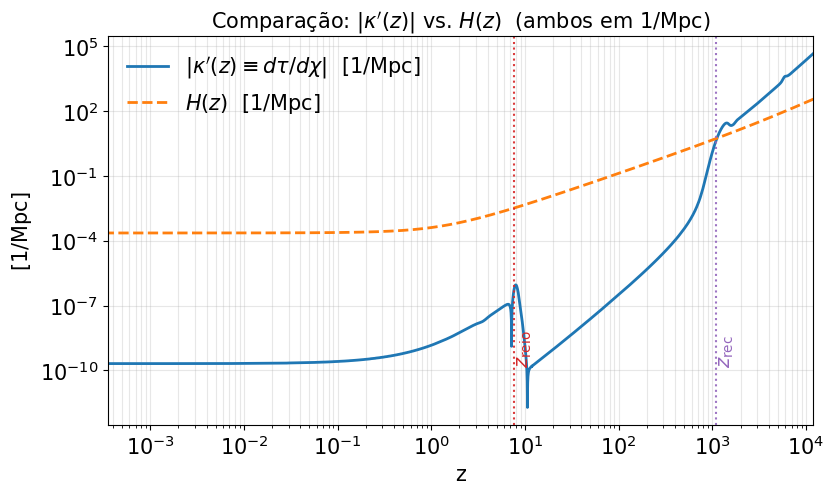

In [22]:
# --- utilidade para pegar colunas por substring (reaproveite se já tiver) ---
def pick_by_substr(d, include, exclude=()):
    include = [s.lower() for s in include]
    exclude = [s.lower() for s in exclude]
    for k in d.keys():
        kl = k.lower()
        if all(s in kl for s in include) and not any(s in kl for s in exclude):
            return k, np.asarray(d[k], dtype=float)
    return None, None

# ========= 1) pegar H(z) em 1/Mpc do background =========
bg = cosmo.get_background()
kz_bg, z_bg = pick_by_substr(bg, ['z'])
kH_bg, H_bg = pick_by_substr(bg, ['h', '[1/mpc'])  # ex.: 'H [1/Mpc]'
a_bg = 1./(1.0 + z_bg)
if z_bg is None or H_bg is None:
    raise RuntimeError(f"Não achei z/H no background. Chaves: {list(bg.keys())}")

# ========= 2) tentar obter kappa'(z) em 1/Mpc diretamente =========
# tenta nomes como 'kappa_prime', 'dkappa/dx', etc.
kkp, kappa_prime = pick_by_substr(thermo, ['kappa', 'prime'])
if kappa_prime is None:
    kkp, kappa_prime = pick_by_substr(thermo, ['dkappa'])  # ex.: 'dKappa/d...' etc.

# ========= 3) fallback: reconstruir kappa'(z) a partir de tau(z) e eta(z) =========
if kappa_prime is None:
    # pegar tau(z) (kappa cumulativa, adimensional)
    kkappa, kappa_tau = pick_by_substr(thermo, ['kappa'], exclude=['prime','dkappa','exp'])
    if kappa_tau is None:
        # reconstruir tau = -ln(exp(-kappa))
        kexp, exp_minus_k = pick_by_substr(thermo, ['exp(-kappa)'])
        if exp_minus_k is None:
            raise RuntimeError("Não encontrei nem kappa, nem exp(-kappa) para reconstruir tau.")
        kappa_tau = -np.log(np.clip(exp_minus_k, 1e-300, 1.0))
    # precisamos de eta(z) em Mpc; costuma estar no background
    keta, eta_bg = pick_by_substr(bg, ['conformal time', '[mpc'])  # ex.: 'conf. time [Mpc]'
    if eta_bg is None:
        # alternativa: 'eta [Mpc]'
        keta, eta_bg = pick_by_substr(bg, ['eta', '[mpc'])
    if eta_bg is None:
        # último recurso: usar a relação deta/dz = -1/[(1+z)H(z)]
        # e derivar tau(z) numericamente em z e converter por cadeia (mais ruidoso).
        # Interpolamos tau(z) para a malha do background (z_bg).
        from numpy import interp, gradient
        kz_th, z_th = pick_by_substr(thermo, ['z'])
        tau_bg = interp(z_bg, z_th, kappa_tau)
        dtaudz = gradient(tau_bg, z_bg)
        detadz = -1.0/((1.0+z_bg)*H_bg)  # Mpc por unidade de z
        kappa_prime = dtaudz / detadz    # (d tau/d z) / (d eta/d z) = d tau/d eta = 1/Mpc
    else:
        # temos eta(z): interpola tau na malha do bg e deriva em eta
        from numpy import interp, gradient
        kz_th, z_th = pick_by_substr(thermo, ['z'])
        tau_bg = interp(z_bg, z_th, kappa_tau)
        kappa_prime = gradient(tau_bg, eta_bg)  # d tau / d eta  [1/Mpc]

# ========= 4) estimar z_reio e z_rec (como antes) =========
z_reio = z_rec = None
try:
    dd = cosmo.get_current_derived_parameters(['z_reio','z_rec'])
    z_reio = float(dd.get('z_reio', np.nan));  z_rec = float(dd.get('z_rec', np.nan))
except Exception:
    pass
if (z_reio is None or not np.isfinite(z_reio)) and g is not None:
    m = (z >= 0) & (z <= 30) & np.isfinite(g);  z_reio = float(z[m][np.argmax(g[m])]) if np.any(m) else 8.0
if (z_rec is None or not np.isfinite(z_rec)) and g is not None:
    m = np.isfinite(g);                             z_rec  = float(z[m][np.argmax(g[m])]) if np.any(m) else 1090.0
if z_reio is None: z_reio = 8.0
if z_rec  is None: z_rec  = 1090.0

# ========= 5) alinhar tudo na mesma malha de z e plotar =========
# Interpolamos kappa'(z) para a malha do background (z_bg), e restringimos intervalo
from numpy import interp
# descobrir qual vetor de z corresponde a kappa_prime (thermo ou bg)
if kkp is not None and 'thermo' in (str(kkp).lower()):
    # improvável; em geral kkp é só o nome da coluna
    z_for_kprime = z
else:
    # mais seguro: se kappa_prime veio de derivada em eta_bg, já está na malha z_bg
    z_for_kprime = z_bg if kappa_prime.shape == z_bg.shape else z

kprime_bg = kappa_prime if kappa_prime.shape == z_bg.shape else interp(z_bg, z_for_kprime, kappa_prime)

zmin, zmax = 0, 12e3
mask = (z_bg >= zmin) & (z_bg <= zmax)

plt.figure(figsize=(8.6,5.2))
plt.loglog(z_bg[mask], np.abs(kprime_bg[mask]), lw=2, label=r"$|\kappa'(z)\equiv d\tau/d\chi|$  [$1/{\rm Mpc}$]")
plt.loglog(z_bg[mask], H_bg[mask],      lw=2, ls='--', label=r"$H(z)$  [$1/{\rm Mpc}$]")

# linhas verticais
for zz, col, lab in [(z_reio, 'tab:red', r'$z_{\rm reio}$'), (z_rec, 'tab:purple', r'$z_{\rm rec}$')]:
    plt.axvline(zz, ls=':', lw=1.5, color=col, alpha=0.9)
    # anotação
    y0, y1 = plt.ylim()
    y_text = np.exp(np.log(y0) + 0.15*np.log(y1/y0))
    plt.text(zz*1.03, y_text, lab, rotation=90, color=col, va='bottom', ha='left', fontsize=14)

plt.xlim(zmin, zmax)
plt.xlabel('z')
plt.ylabel(r'[$1/{\rm Mpc}$]')
plt.title(r"Comparação: $|\kappa'(z)|$ vs. $H(z)$  (ambos em $1/{\rm Mpc}$)")
plt.grid(alpha=0.3, which='both')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


# Por que $\kappa'(z)$ é maior que $H(z)$ antes da recombinação?

## Definições e comparação justa
- Definimos $\kappa' \equiv \dfrac{d\tau}{d\chi}$ (ou $\dot\tau \equiv d\tau/d\eta$). No CLASS, com \(c=1\),
$
  \kappa' \;=\; a\,n_e\,\sigma_T \quad (\text{unid. } 1/{\rm Mpc}).
$
- Para comparar com a expansão, usamos $H(z)$ em $1/{\rm Mpc}$ (ou, de forma equivalente para tempo conforme, $\mathcal{H}=aH$). Assim, ambos medem “taxas por comprimento comóvel”.

## Antes da recombinação: regime de acoplamento forte (tight coupling)
- O plasma é **fortemente ionizado**: $x_e\simeq 1$, logo $n_e \propto (1+z)^3$ é grande.
- Então $\kappa'=a n_e \sigma_T$ é **alto** $\Rightarrow$ o **caminho livre médio comóvel**
$
  \lambda_c=\frac{1}{\kappa'}=\frac{1}{a\,n_e\,\sigma_T}
$
  é **muito menor** que o **comprimento de Hubble comóvel** $\sim 1/H$.
- Em termos de taxas: $\dot\tau \gg \mathcal{H}$ (ou $\kappa' \gg H$). O fóton sofre **muitos espalhamentos** dentro de um tempo de Hubble $\Rightarrow$ **fluido fóton–bárion** bem acoplado, **oscilação acústica** e **difusão** (Silk damping) nos altos $\ell$.

## Recombinação: condição de “último espalhamento”
- Quando os elétrons **recombinam** ($z\sim 1100$), $n_e$ **despenca**.
- O “último espalhamento” ocorre quando $\dot\tau$ cai até ficar **comparável** à expansão $(\dot\tau\sim \mathcal{H}$).
- A **função de visibilidade** $g(\eta)=\dot\tau\,e^{-\tau}$ tem então um **pico estreito**, assinalando o **desacoplamento**.

## Depois da recombinação: free streaming
- Com $x_e\ll 1$ (ionização residual), $\kappa'$ torna‑se **minúsculo** $\Rightarrow$ $\lambda_c$ é **enorme** (maior que o horizonte), e os fótons **viajam livremente**. É o CMB que observamos hoje.

## Reionização: subida modesta de $\kappa'$
- Em $z\sim 6\text{–}10$, fontes astrofísicas **reionizam** o meio, elevando $n_e$ e $\kappa'$.
- Ainda assim, $\kappa' \ll H$: o Universo é **quase transparente**, havendo apenas reespalhamento **raro** que gera o **reionization bump** em $C_\ell^{EE}$ para $\ell$ baixos.

---

### Em resumo
Ver $|\kappa'| > H$ **antes da recombinação** é esperado: o **ritmo de espalhamento Thomson por comprimento comóvel** domina a expansão, caracterizando o **acoplamento forte fóton–bárion**. A inversão $\kappa' \ll H$ após a recombinação marca o **desacoplamento** e o **free streaming** do CMB.